<a href="https://colab.research.google.com/github/Soedirman-Machine-Learning/dl-time-series-forecasting/blob/main/VAR_Multivariat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Soedirman-Machine-Learning/dl-time-series-forecasting

Cloning into 'dl-time-series-forecasting'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 97 (delta 42), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (97/97), done.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from pandas import read_csv

df = pd.read_csv('https://raw.githubusercontent.com/Soedirman-Machine-Learning/dl-time-series-forecasting/main/dataset_multivariat.csv')

print(df.shape)
df.tail()


(2394, 8)


,u1,u2,u3,u4,u5,u6,u7,y
2389,0.284859,0.645894,0.688723,0.355109,0.615583,0.608848,0.500866,0.188976
2390,0.266139,0.665503,0.665640,0.354275,0.588834,0.582074,0.508999,0.178992
2391,0.247419,0.665706,0.664740,0.353441,0.561301,0.602186,0.523348,0.169742
2392,0.228699,0.672975,0.677300,0.352607,0.530730,0.636970,0.537697,0.159023
2393,0.215821,0.668945,0.677877,0.351774,0.500161,0.684994,0.569601,0.149922


In [3]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)

,u1_x,u2_x,u3_x,u4_x,u5_x,u6_x,u7_x,y_x
u1_y,1.0,0.0001,0.0,0.0001,0.0000,0.0000,0.0000,0.0000
u2_y,0.0,1.0000,0.0,0.4507,0.0002,0.0213,0.0117,0.0012
u3_y,0.0,0.0000,1.0,0.0000,0.0000,0.0000,0.0000,0.0631
u4_y,0.0,0.0000,0.0,1.0000,0.0049,0.0002,0.0015,0.2333
u5_y,0.0,0.0000,0.0,0.0002,1.0000,0.0000,0.0000,0.0000
u6_y,0.0,0.0000,0.0,0.0000,0.0000,1.0000,0.0000,0.0006
u7_y,0.0,0.0000,0.0,0.0000,0.0000,0.0000,1.0000,0.0000
y_y,0.0,0.0000,0.0,0.0406,0.0000,0.0000,0.0000,1.0000


In [4]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)


Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
u1     ::  542.53    > 143.6691  =>   True
u2     ::  312.81    > 111.7797  =>   True
u3     ::  210.11    > 83.9383   =>   True
u4     ::  150.74    > 60.0627   =>   True
u5     ::  92.79     > 40.1749   =>   True
u6     ::  43.42     > 24.2761   =>   True
u7     ::  6.14      > 12.3212   =>   False
y      ::  0.2       > 4.1296    =>   False


In [5]:
nobs = 479
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)
print(df_test.shape)  

(1915, 8)
(479, 8)


In [6]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [7]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "u1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.83
 No. Lags Chosen       = 13
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "u2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.6339
 No. Lags Chosen       = 26
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "u3" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test 

In [8]:
model = VAR(df_train)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -61.361054246283246
BIC :  -61.152015353292164
FPE :  2.245085980359479e-27
HQIC:  -61.2841287732805 

Lag Order = 2
AIC :  -64.45733780674242
BIC :  -64.06231731335826
FPE :  1.0151623395036793e-28
HQIC:  -64.31196801277522 

Lag Order = 3
AIC :  -64.87284928768918
BIC :  -64.29168766701854
FPE :  6.700152802801926e-29
HQIC:  -64.65897284644241 

Lag Order = 4
AIC :  -64.98698562294845
BIC :  -64.21952312515702
FPE :  5.977542572551816e-29
HQIC:  -64.70454011850427 

Lag Order = 5
AIC :  -65.0292238953119
BIC :  -64.07530054719601
FPE :  5.730464370835889e-29
HQIC:  -64.67814682197445 

Lag Order = 6
AIC :  -65.05234130414102
BIC :  -63.91179690869813
FPE :  5.599720134994799e-29
HQIC:  -64.63257006626083 

Lag Order = 7
AIC :  -65.05243527252212
BIC :  -63.72510940852015
FPE :  5.59948537815597e-29
HQIC:  -64.56390718431979 

Lag Order = 8
AIC :  -65.05108721474751
BIC :  -63.53681923629328
FPE :  5.607426197428617e-29
HQIC:  -64.49373950013722 

Lag Order = 9
AI

In [9]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,-39.19,-39.17,9.549e-18,-39.18
1,-61.33,-61.12,2.319e-27,-61.25
2,-64.43,-64.03,1.046e-28,-64.28
3,-64.85,-64.26*,6.877e-29,-64.63
4,-64.96,-64.19,6.113e-29,-64.68*
5,-65.01,-64.05,5.845e-29,-64.66
6,-65.04,-63.89,5.697e-29,-64.61
7,-65.04,-63.71,5.680e-29,-64.55
8,-65.04,-63.52,5.685e-29,-64.48
9,-65.05,-63.35,5.590e-29,-64.43


In [10]:
model_fitted = model.fit(7)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 15, Nov, 2021
Time:                     13:37:03
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                   -63.7251
Nobs:                     1908.00    HQIC:                  -64.5639
Log likelihood:           40857.3    FPE:                5.59949e-29
AIC:                     -65.0524    Det(Omega_mle):     4.42461e-29
--------------------------------------------------------------------
Results for equation u1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.013320         0.007709            1.728           0.084
L1.u1         1.419870         0.024698           57.490           0.000
L1.u2         0.049776         0.013593            3.662           0.000
L1.u3        -0.055108

In [11]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print((col), ':', round(val, 2))

u1 : 2.0
u2 : 2.0
u3 : 2.0
u4 : 2.0
u5 : 2.0
u6 : 2.01
u7 : 2.03
y : 2.02


In [12]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 2

# Input data for forecasting
forecast_input = df_train.values[-lag_order:]
forecast_input

7


array([[0.20543619, 0.72107991, 0.62135622, 0.36090053, 0.67439745,
        0.5503028 , 0.49791024, 0.33258951],
       [0.20716735, 0.70401114, 0.62934437, 0.36087621, 0.65726242,
        0.46127412, 0.46295718, 0.32795019],
       [0.21121225, 0.69174651, 0.62373156, 0.3608519 , 0.64632401,
        0.47156315, 0.42516628, 0.32117267],
       [0.2207292 , 0.68802584, 0.61617889, 0.36082759, 0.63440255,
        0.47455049, 0.42516628, 0.31250043],
       [0.23024615, 0.73054225, 0.61558304, 0.360803  , 0.65576024,
        0.50924839, 0.45308638, 0.30470063],
       [0.23976374, 0.71225438, 0.61882933, 0.36077869, 0.65910366,
        0.51916968, 0.47692938, 0.29332157],
       [0.2492807 , 0.72077919, 0.63372596, 0.36075437, 0.66431068,
        0.55463437, 0.49966675, 0.28105612]])

In [13]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_pred')
df_forecast


,u1_pred,u2_pred,u3_pred,u4_pred,u5_pred,u6_pred,u7_pred,y_pred
1915,0.260909,0.717143,0.651885,0.364295,0.670894,0.557307,0.515510,0.270722
1916,0.273019,0.716554,0.665222,0.370955,0.675114,0.554057,0.513273,0.261669
1917,0.280166,0.715825,0.678328,0.373451,0.675717,0.550332,0.506952,0.254484
1918,0.286338,0.711965,0.683890,0.375239,0.674435,0.542336,0.498187,0.248147
1919,0.288827,0.709990,0.689854,0.377365,0.672150,0.538695,0.493803,0.243618
...,...,...,...,...,...,...,...,...
2389,0.287957,0.668420,0.661744,0.431184,0.651343,0.563209,0.529392,0.261302
2390,0.287942,0.668418,0.661699,0.431204,0.651362,0.563264,0.529451,0.261301
2391,0.287928,0.668417,0.661654,0.431225,0.651381,0.563319,0.529510,0.261301
2392,0.287914,0.668415,0.661610,0.431246,0.651400,0.563375,0.529568,0.261300


In [14]:
df_forecast.loc[:, ['y_pred']]

,y_pred
1915,0.270722
1916,0.261669
1917,0.254484
1918,0.248147
1919,0.243618
...,...
2389,0.261302
2390,0.261301
2391,0.261301
2392,0.261300


In [15]:
df

,u1,u2,u3,u4,u5,u6,u7,y
0,0.268900,0.650894,0.832742,0.583420,0.784759,0.843079,0.822079,0.180295
1,0.268483,0.650140,0.852153,0.577510,0.776487,0.838605,0.822079,0.177124
2,0.267967,0.659657,0.823618,0.571600,0.764546,0.807879,0.786246,0.173618
3,0.267451,0.668338,0.808371,0.565689,0.752605,0.799606,0.786246,0.171640
4,0.266935,0.647191,0.761948,0.559779,0.745326,0.773122,0.746142,0.166972
...,...,...,...,...,...,...,...,...
2389,0.284859,0.645894,0.688723,0.355109,0.615583,0.608848,0.500866,0.188976
2390,0.266139,0.665503,0.665640,0.354275,0.588834,0.582074,0.508999,0.178992
2391,0.247419,0.665706,0.664740,0.353441,0.561301,0.602186,0.523348,0.169742
2392,0.228699,0.672975,0.677300,0.352607,0.530730,0.636970,0.537697,0.159023


In [16]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape,'mae': mae, 
             'rmse':rmse})

print('Forecast Accuracy of: y')
accuracy_prod = forecast_accuracy(df_forecast['y_pred'].values, df_test['y'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))


Forecast Accuracy of: y
mape :  inf
mae :  0.165
rmse :  0.2061


In [17]:
y_predictions = df_forecast['y_pred']
y_aktual = df_test['y']

Text(0.5, 1.0, 'nilai y')

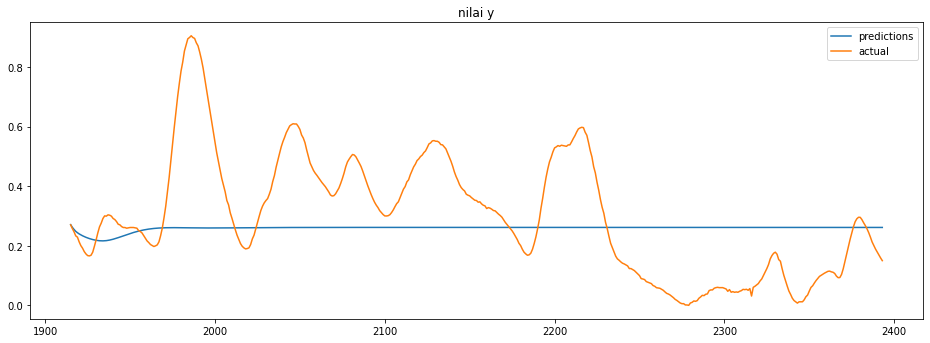

In [18]:
from matplotlib.pyplot import figure
plt.figure(1)
plt.subplot(211)
y_predictions.plot(figsize = (16,12), label ="predictions")
y_aktual.plot(figsize = (16,12), label = "actual")
plt.legend(fontsize=10)
plt.title('nilai y')

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_prediksi = y_predictions.to_numpy()
y_uji = y_aktual.to_numpy()

MAE = mean_absolute_error(y_uji, y_prediksi)
print(f'Mean Absolute Error (MAE): {np.round(MAE, 2)}')

MDAPE = np.median((np.abs(np.subtract(y_uji, y_prediksi)/y_uji ))) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

RMSE = np.sqrt(np.mean(np.square(y_prediksi - y_uji)))
print(f'Root Mean Square Error (RMSE): {np.round(RMSE, 2)}')

MAPE = np.mean((np.abs(np.subtract(y_uji, y_prediksi)/ y_uji))) * 100
print(f'Mean Absolute Percentage Error (MAPE):{np.round(MAPE, 2)} %')

Mean Absolute Error (MAE): 0.17
Median Absolute Percentage Error (MDAPE): 46.44 %
Root Mean Square Error (RMSE): 0.21
Mean Absolute Percentage Error (MAPE):inf %


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
